## Automatización de Clasificación de Enfermendades

  Todo contacto clínico de un paciente con el sistema de salud implica un diagnostico, emitido por el profesional de salud. Los diagnosticos médicos generalmente vienen en formato de texto plano con explicación adicional por lo que la extracción manual de dicha información es tediosa. Así, los sistemas de información hospitalaria (historia y expediente clinicos) se ven en la obligación de estandarizar y homologar los procedimientos clínicos mediante la Clasificación Internacional de Enfermedades (CIE), lo que implica costos adicionales, demora en el procesamiento e integración de la información y conformación de los expedientes, errores en la retranscripción y codificación, sobre todo en la toma de decisión.
   
  La clasificación y codificación CIE, determina las enfermedades y una amplia
  variedad de signos, síntomas, hallazgos anormales, denuncias, circunstancias sociales y
  causas externas de daños y/o enfermedad. No solo se usa para la toma de decisión a nivel hospitalario sino también orienta las decisiones de salud pública. 

  Así que la tarea de automatización de los diagnosticos médicos es fundamental para mejorar los procesos de integración de la información de morbilidad y mortalidad desde un consultorio hasta las oficinas de gobierno. Se propone en una primera etapa un clasificador que consiste en extraer, independientemente de la fuente de información (datos estructurados y no estructurados), los diagnosticos médicos para su asociación y clasificación con la CIE. Para esto, se ha clasificado con alrededor de 91% de precisión las primeras 20 principales causas de muertes con un conjunto de 8 millones de registros de mortalidad en México entre 2010 y 2020. Este ejercicio ayudará a fortalecer el sistema de información en salud e incrementar su eficiencia y productividad.



In [1]:
import pandas as pd
import numpy as np
import re, string, os
from unidecode import unidecode
from tqdm import tqdm 
tqdm.pandas()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, GRU, Bidirectional,Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, legacy
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import backend as K
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, RobertaTokenizer, DistilBertTokenizer
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, DistilBertForSequenceClassification
from transformers import AdamW, get_scheduler
import torch

import itertools
import matplotlib.pyplot as plt
#import seaborn as sns


### Helpers functions

In [2]:
# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available, using CPU instead.")


1 Physical GPUs, 1 Logical GPU


2024-06-04 15:27:05.187109: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-04 15:27:05.187134: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-06-04 15:27:05.187139: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-06-04 15:27:05.187170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-04 15:27:05.187187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
## Read and preprocessing data
def read_file(path):
    df = pd.read_pickle(path).reset_index(drop=True)
    cols = ['sexo', 'edad', 'res_ent', 'def_ent', 'causa_bas', 'des_causa_a',
            'des_causa_b', 'des_causa_c', 'causa_a', 'causa_b', 'causa_c']
    df = df[cols]

    def remove_characters(text):
        if isinstance(text, str):
            text = text.lower()
            text = unidecode(text)
            punctuation = '''|!()-[]{};:'"\,<>./?@#$%^&*_~'''
            text = text.translate(str.maketrans('', '', punctuation))
            text = re.sub(r'-','', text)
            text = text.strip()
        return text
    
    text_cols = ['des_causa_a', 'des_causa_b', 'des_causa_c']
    for col in text_cols:
        df[col] = df[col].apply(remove_characters)

    results = []
    for i, col in enumerate(text_cols):
        code_col = f'causa_{chr(97+i)}'
        result = df[['sexo', 'edad', 'res_ent', 'def_ent', 'causa_bas', col, code_col]].rename(
            columns={col: 'diagnostico', code_col: 'codigo'}
        ).dropna()
        results.append(result)

    result = pd.concat(results, ignore_index=True)
    result['codigo'] = result['codigo'].apply(remove_characters)
    result['len_codigo'] = result['codigo'].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
    
    #filter the first 100 causes
    result = result[(result.len_codigo == 1) & (result.codigo.isin(result.codigo.value_counts()[:30].index))]
    
    # Calculate frequencies and determine order
    value_counts = result['codigo'].value_counts()

    labels_mapping = {value: label for label, value in enumerate(value_counts.index)}

    # Apply the mapping to the dataframe to create a new 'label' column
    result['label'] = result['codigo'].map(labels_mapping)
    result = result[pd.notnull(result.codigo)].sort_values('label')
    result['causa'] = result.loc[:,['sexo','edad','diagnostico']].progress_apply(lambda x: ' '.join(x.astype(str)), axis=1)
    result = result[['diagnostico','codigo','label']]
    return result  

## Read data

In [5]:
path = '/Users/pierredelice/Dropbox/Mac/Documents/GitHub/ex1_sinac_seed/causa_seed/seedcausa.pkl'
df = read_file(path)

100%|██████████| 11017749/11017749 [02:09<00:00, 85383.61it/s]


# Models

Training BiGRU
Epoch 1/15


/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2498/2500 [============================>.] - ETA: 0s - loss: 0.2986 - accuracy: 0.9226 - f1_score: 0.9882

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


2500/2500 [==============================] - 63s 24ms/step - loss: 0.2986 - accuracy: 0.9226 - f1_score: 0.9882 - val_loss: 0.1557 - val_accuracy: 0.9613 - val_f1_score: 0.9917
Epoch 2/15
2500/2500 [==============================] - 60s 24ms/step - loss: 0.1370 - accuracy: 0.9628 - f1_score: 0.9905 - val_loss: 0.1403 - val_accuracy: 0.9627 - val_f1_score: 0.9917
Epoch 3/15
2500/2500 [==============================] - 61s 24ms/step - loss: 0.1250 - accuracy: 0.9647 - f1_score: 0.9907 - val_loss: 0.1451 - val_accuracy: 0.9630 - val_f1_score: 0.9916
Epoch 4/15
2500/2500 [==============================] - 61s 24ms/step - loss: 0.1218 - accuracy: 0.9659 - f1_score: 0.9907 - val_loss: 0.1448 - val_accuracy: 0.9629 - val_f1_score: 0.9917
Epoch 5/15
2500/2500 [==============================] - 61s 24ms/step - loss: 0.1207 - accuracy: 0.9659 - f1_score: 0.9906 - val_loss: 0.1455 - val_accuracy: 0.9629 - val_f1_score: 0.9916
Epoch 6/15
2500/2500 [==============================] - 60s 24ms/step -

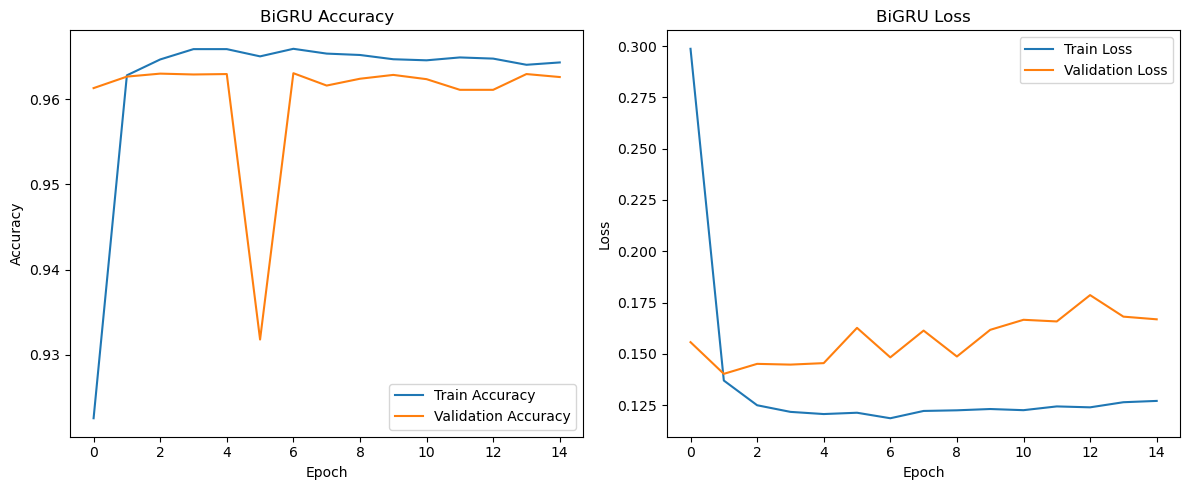

INFO:tensorflow:Assets written to: saved_models/BiGRU/assets


INFO:tensorflow:Assets written to: saved_models/BiGRU/assets


Model saved at: saved_models/BiGRU
          Train                     Validation                   
           Loss  Accuracy  F1-Score       Loss Accuracy  F1-Score
Model                                                            
BiGRU  0.127092  0.964312  0.989865   0.166847   0.9626  0.991678
625/625 [==============================] - 6s 9ms/step
Best Model: BiGRU
Accuracy: 0.9626
Recall: 0.9575584985335326
Precision: 0.9595013972282492
F1-Score: 0.9553512251292018
Confusion Matrix:
[[ 372    0    0    0    0    1    0    0    0    0    1    0   11    0
     0    0    0    1    0    0    0    0    0    0    1  302    0    0
     0]
 [   0  991    9    0    0    4    0    1    2    0    4    0    0    1
     0    0    0    0    0    0    1    0    0    0    0    0    0    0
     0]
 [   0    4  413    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    1    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0  630    3    0    0    0    0    0

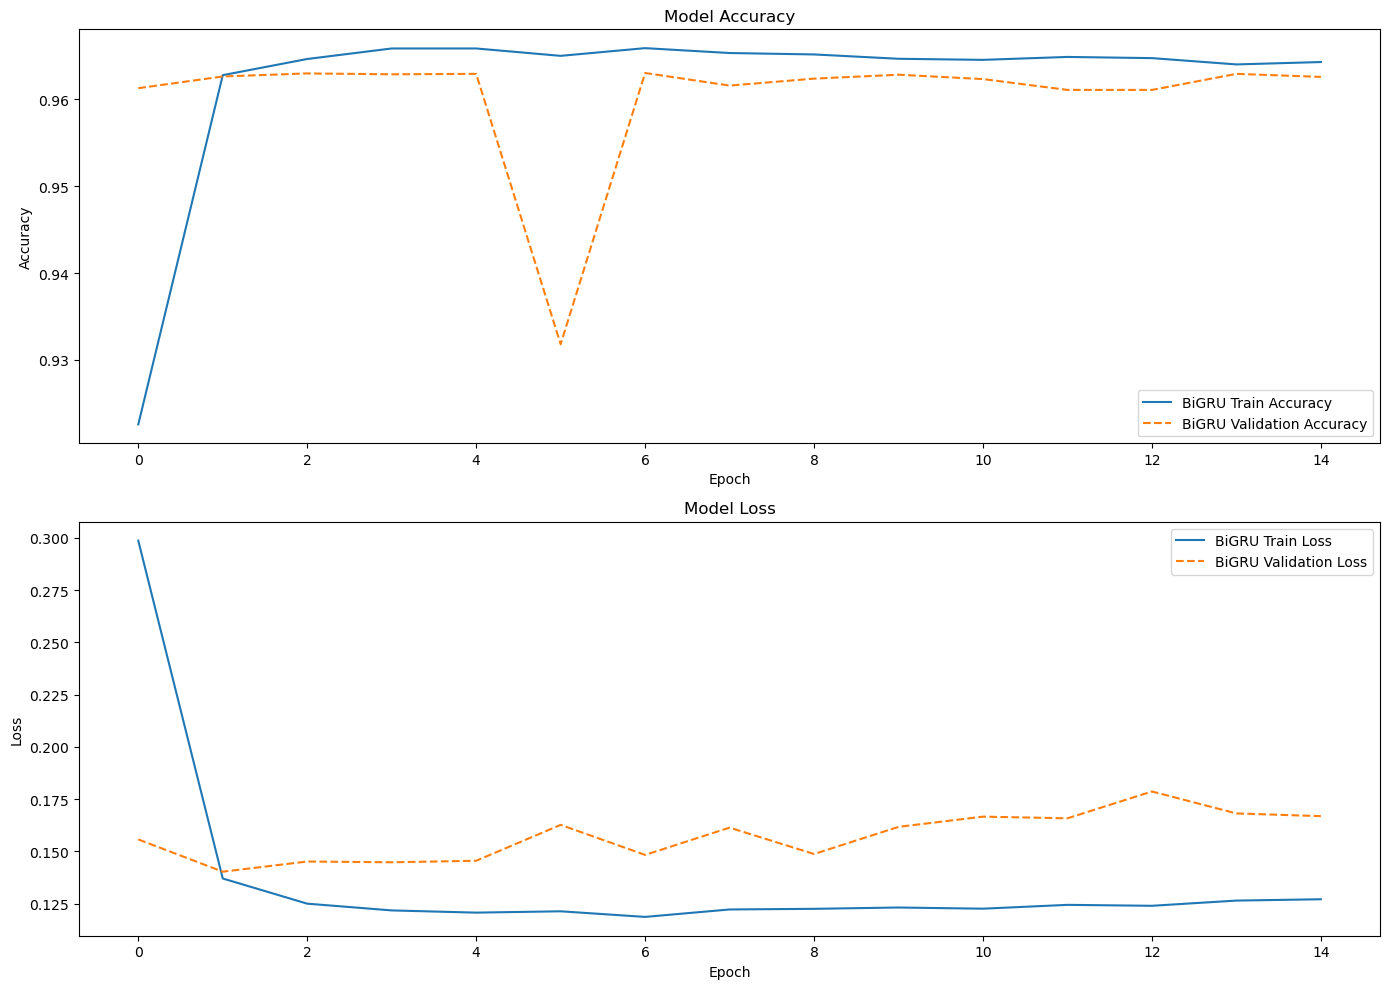

In [7]:
# Model parameters for TensorFlow models
vocab_size = 50_000
embedding_dim = 100
max_length = 128
patience = 3  # Early stopping patience
batch_size = 8  # Batch size
num_epochs = 15  # Number of epochs
random_state = 123
test_size= 0.2
sample_size = 100_000

# Sample and prepare the data
df = df.sample(sample_size, random_state=random_state)
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['diagnostico'])
sequences = tokenizer.texts_to_sequences(df['diagnostico'])
max_length = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
labels = df['codigo'].astype('category').cat.codes
num_classes = len(np.unique(labels))


# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, 
                                                    test_size=test_size, 
                                                    random_state=random_state)

# Define F1-score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to labels
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.reshape(y_true, [-1])
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.int32)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Define and compile models with additional layers, neurons, dropout, and new metrics
models = {
    'MLP': Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ]),
    'CNN': Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ]),
    'LSTM': Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        LSTM(256, return_sequences=True),
        Dropout(0.5),
        LSTM(128),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ]),
    'BiGRU': Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(GRU(128, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(GRU(64)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
}

# Directory for saving models and plots
model_dir = 'saved_models'
plot_dir = 'model_plots'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# Train, evaluate, and save each model
histories = {}
evaluation_results = []

for model_name, model in models.items():
    if 'BiGRU' in model_name:
        print(f"Training {model_name}")
        model.compile(
            loss=SparseCategoricalCrossentropy(),
            optimizer=legacy.Adam(lr=0.001),  # Reduced learning rate
            metrics=['accuracy',F1Score()]
        )
        history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test))
        histories[model_name] = history
        results = model.evaluate(X_test, y_test)
        print(f"{model_name} - Results: {results}")
        
        # Extract evaluation metrics
        train_f1 = history.history['f1_score'][-1]
        val_f1 = history.history['val_f1_score'][-1]
        final_loss = history.history['loss'][-1]
        final_accuracy = history.history['accuracy'][-1]
        val_loss = history.history['val_loss'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        
        evaluation_results.append({
            'Model': model_name,
            'Train Loss': final_loss,
            'Train Accuracy': final_accuracy,
            'Train F1-Score': train_f1,
            'Validation Loss': val_loss,
            'Validation Accuracy': val_accuracy,
            'Validation F1-Score': val_f1
        })

        # Plot and save accuracy and loss figures
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        # Save the plot before showing it
        plot_path = os.path.join(plot_dir, f'{model_name}_plot.png')
        plt.savefig(plot_path)
        print(f"Plot saved at: {plot_path}")
        plt.show()

        # Save the model
        model_path = os.path.join(model_dir, model_name)
        model.save(model_path)
        print(f"Model saved at: {model_path}")

# Convert the results to a DataFrame with multi-index columns
results_df = pd.DataFrame(evaluation_results)
results_df.set_index('Model', inplace=True)
results_df.columns = pd.MultiIndex.from_tuples(
    [('Train', 'Loss'), ('Train', 'Accuracy'), ('Train', 'F1-Score'),
    ('Validation', 'Loss'), ('Validation', 'Accuracy'), ('Validation', 'F1-Score')]
)

# Sort by Validation Accuracy
results_df = results_df.sort_values(by=('Validation', 'Accuracy'), ascending=False)
print(results_df)

# Load the best model
best_model_name = results_df.index[0]
best_model_path = os.path.join(model_dir, best_model_name)
best_model = load_model(best_model_path, custom_objects={'F1Score': F1Score})

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Return statistics
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes, average='macro')
precision = precision_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_report = classification_report(y_test, y_pred_classes)

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

# Combined plot
plt.figure(figsize=(14, 10))

# Plot accuracy
plt.subplot(2, 1, 1)
for model_name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
    plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{model_name} Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(2, 1, 2)
for model_name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'{model_name} Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'combined_plot.png'))
plt.show()


In [8]:

# Load the best model (assuming best model directory path is known)
best_model_path = 'saved_models/BiGRU/'
best_model = load_model(best_model_path, custom_objects={'F1Score': F1Score})


In [77]:
df_predict = pd.DataFrame(
  {'diag':
   ['el paciente que murio por diabetes mellitus habia llegado con con dolor de cabeza',
    'el niño murio por cancer pero tambien sufrio de lesiones',
    'murio por hipertension pero tambien sufria de asma',
    'tenia neumonia severa y dolor de cabeza',
    'causa indeterminada',
    ]
    })


new_sequences = tokenizer.texts_to_sequences(df_predict['diag'])

new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length, padding='post')

predictions = best_model.predict(new_padded_sequences)

predicted_classes = np.argmax(predictions, axis=1)

category_mapping = dict(enumerate(df['codigo'].astype('category').cat.categories))

predicted_labels = [category_mapping[code] for code in predicted_classes]

df_predict['Predicted Label'] = predicted_labels
df_predict

1/1 [==============================] - 0s 21ms/step


,diag,Predicted Label
0,el paciente que murio por diabetes mellitus ha...,i10x
1,el niño murio por cancer pero tambien sufrio d...,i509
2,murio por hipertension pero tambien sufria de ...,i10x
3,tenia neumonia severa y dolor de cabeza,j189
4,causa indeterminada,r688


In [78]:
def prediccion(causa):
  tdf = pd.DataFrame({'diag':[causa]})
  seq = tokenizer.texts_to_sequences(tdf['diag'])
  pad = pad_sequences(seq, maxlen=max_length, padding='post')
  pred = best_model.predict(pad)
  icls = np.argmax(pred, axis=1)
  clase = [category_mapping[y] for y in icls]

  return clase[0]

In [83]:
causa = input("Escribe la razon: ")
prediccion(causa)
print(causa)

1/1 [==============================] - 0s 22ms/step
ingreso con diabetes


In [84]:
prediccion(causa)

1/1 [==============================] - 0s 19ms/step


'e149'